# Explore here

In [1]:
import pandas as pd

In [2]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df = pd.read_csv(url)

df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
df.shape

(366, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


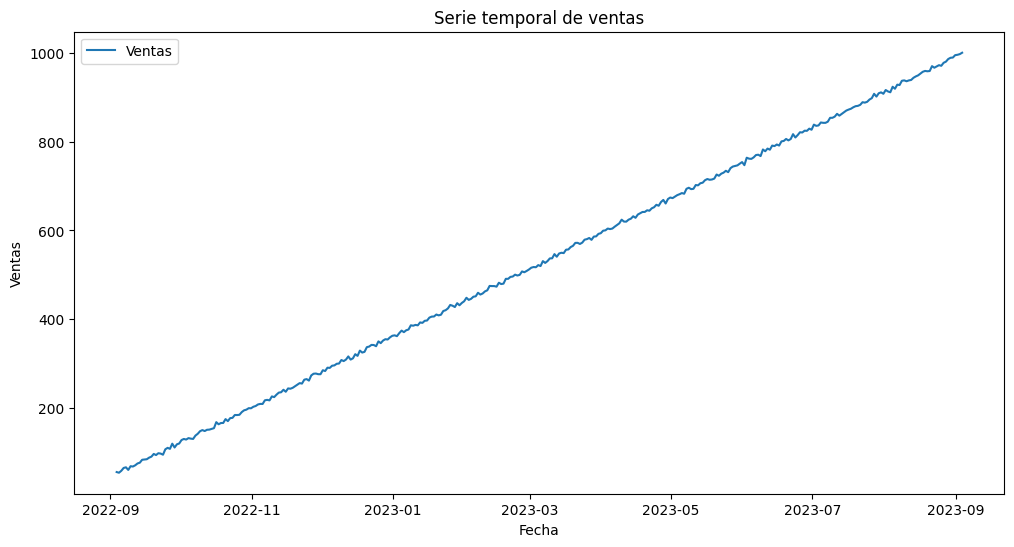

In [5]:
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Grafica
plt.figure(figsize=(12, 6))
plt.plot(df['sales'], label='Ventas')
plt.title('Serie temporal de ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

¿Cuál es el tensor de la serie temporal?
¿Cuál es la tendencia?
¿Es estacionaria?
¿Existe variabilidad o presencia de ruido?

In [6]:
# ¿Cuál es el tensor de la serie temporal?
df.index.to_series().diff().value_counts()


date
1 days    365
Name: count, dtype: int64

In [7]:
# El tensro es diario y se puede observar en el gráfico que hay una tendencia creciente en las ventas a lo largo del tiempo. 
# a simple vista no parece haber estacionalidad, pero se recomienda realizar un análisis más detallado para confirmarlo de ADF
# Estacionaria = su media y varianza no cambian con el tiempo (sin tendencia ni estacionalidad).

In [8]:
# ADF
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.545414193706381
p-value: 0.9861899815311065


In [9]:
# No es estacionaria porque el p-valor es mayor a 0.05, lo que indica que la serie temporal tiene una tendencia o estacionalidad.
# Una serie tiene tendencia cuando sus valores muestran un comportamiento sostenido hacia arriba o hacia abajo en el tiempo.

In [10]:
# Diferenciación de primer orden
df['sales_diff'] = df['sales'].diff().dropna()

# Volver a probar estacionariedad

from statsmodels.tsa.stattools import adfuller
result_diff = adfuller(df['sales_diff'].dropna())
print('ADF Statistic (diferenciada):', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic (diferenciada): -9.430263118334734
p-value: 5.212954111417252e-16


Una observación, por que no usar train_test_split: 

Las series temporales tienen dependencia temporal: lo que pasa hoy depende de lo que pasó ayer.

Si usas train_test_split, cortas la serie al azar, rompiendo el orden cronológico ( el modelo vería "futuros mezclados con pasados", lo cual no tiene sentido en una serie temporal.)

✅ ¿Qué se debe hacer?
Usar una división secuencial: tomar el principio como entrenamiento y el final como prueba, respetando el orden del tiempo.
CORTE SECUENCIAL ([:-n])


In [11]:
# definimos el train y test

train = df['sales'][:-30] #Todo menos los últimos 30 días
test = df['sales'][-30:] #Los últimos 30 días

Parámetro	Nombre completo	¿Qué hace?

p	AutoRegresivo (AR)	Número de pasos pasados que el modelo usa (lags).

d	Integrado (I)	Número de veces que se diferencia la serie para volverla estacionaria.

q	Media Móvil (MA)	Número de rezagos en los errores pasados que el modelo usa.

In [14]:
from pmdarima import auto_arima

# auto_arima encuentra p, d, q automáticamente
model_auto = auto_arima(
    train,
    seasonal=False,  # No hay estacionalidad en los datos
    d=1,             # y aesta diferenciado 1 vez
    trace=True,      # ver los modelos que prueba
    stepwise=True    # Hace la búsqueda más rápida
)

model_auto.summary()



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1698.355, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1933.617, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1820.331, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1696.166, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2035.035, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1695.455, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1697.326, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1700.165, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1695.371, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1697.342, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1994.505, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 2.514 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  336
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -843.685
Date:                Wed, 16 Jul 2025   AIC                           1695.371
Time:                        09:37:37   BIC                           1710.627
Sample:                    09-03-2022   HQIC                          1701.453
                         - 08-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5955      0.011    241.858      0.000       2.575       2.617
ma.L1         -1.0345      0.051    -20.159      0.000      -1.135      -0.934
ma.L2          0.0966      0.051      1.891      0.059      -0.004       0.197
sigma2         8.9567      0.731     12.256      0.000       7.524      10.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.98   Prob(JB):                         0.73
Heteroskedasticity (H):               0.88   Skew:                             0.07
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Entrenar el modelo Arima 

from statsmodels.tsa.arima.model import ARIMA

# modelo con los parámetros sugeridos en auto_arima
model = ARIMA(train, order=(0, 1, 2))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  336
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -994.253
Date:                Wed, 16 Jul 2025   AIC                           1994.505
Time:                        09:50:44   BIC                           2005.948
Sample:                    09-03-2022   HQIC                          1999.067
                         - 08-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3188      0.057     -5.552      0.000      -0.431      -0.206
ma.L2          0.3623      0.056      6.453      0.000       0.252       0.472
sigma2        22.1305      1.802     12.279      0.0

c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


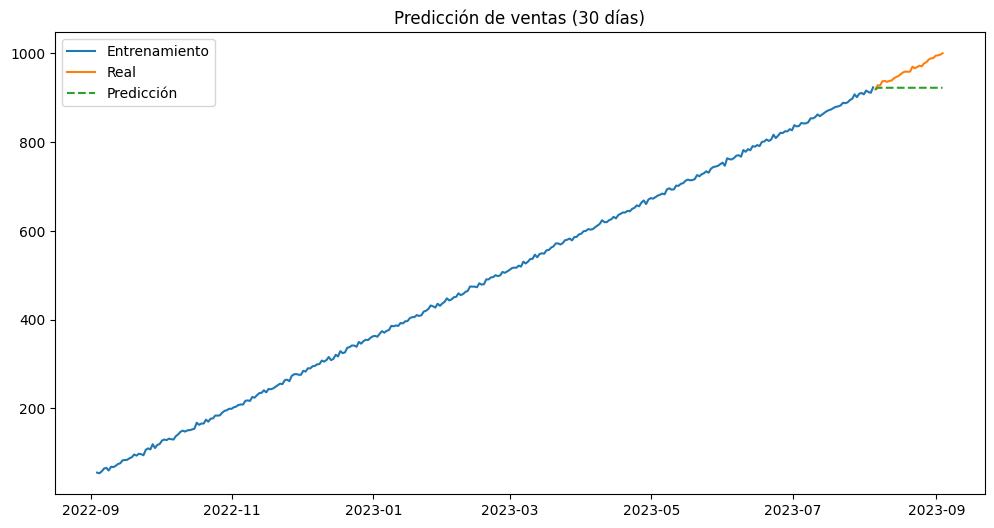

In [20]:
# Predicción de 30 pasos hacia adelante
forecast = model_fit.forecast(steps=30)
forecast.index = test.index  # Alinear con las fechas reales

# Visualizar predicción vs real
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Real')
plt.plot(forecast, label='Predicción', linestyle='--')
plt.title('Predicción de ventas (30 días)')
plt.legend()
plt.show()


In [24]:
# Modelo no capta la tendencia porque d=1 la eliminó

# vasmo a probar con d=2 para ver si capta la tendencia

from statsmodels.tsa.arima.model import ARIMA

# modelo con los parámetros sugeridos en auto_arima
model_1 = ARIMA(train, order=(2, 1, 2))
model_fit_1 = model.fit()

print(model_fit_1.summary())

c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\felip

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  336
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -850.101
Date:                Wed, 16 Jul 2025   AIC                           1710.202
Time:                        09:53:44   BIC                           1729.273
Sample:                    09-03-2022   HQIC                          1717.805
                         - 08-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8990      0.013     71.403      0.000       0.874       0.924
ar.L2          0.1010      0.013      8.022      0.000       0.076       0.126
ma.L1         -1.9110      0.026    -73.976      0.0

c:\Users\felip\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


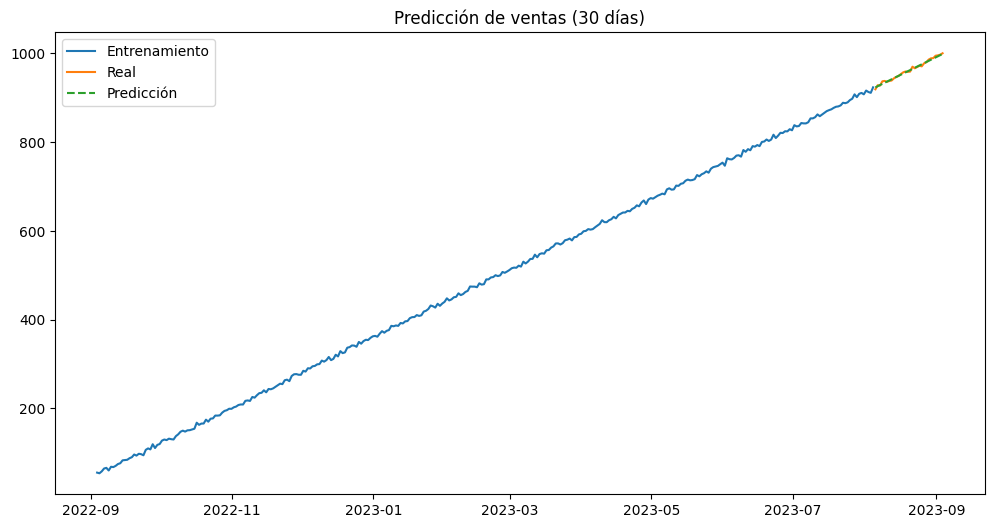

In [26]:
# Predicción de 30 pasos hacia adelante
forecast_2 = model_fit_1.forecast(steps=30)
forecast.index = test.index  # Alinear con las fechas reales

# Visualizar predicción vs real
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Real')
plt.plot(forecast_2, label='Predicción', linestyle='--')
plt.title('Predicción de ventas (30 días)')
plt.legend()
plt.show()


Nuestro modelo ARIMA predice las ventas para los próximos 30 días con alta precisión.
Podemos observar que la tendencia es claramente creciente, lo que implica que nuestra operación necesita prepararse para una mayor demanda

In [27]:
#METRICA

from sklearn.metrics import mean_squared_error
import numpy as np

# Calcular RMSE entre valores reales y predichos
rmse = np.sqrt(mean_squared_error(test, forecast_2))
print(f"RMSE: {rmse:.2f}")


RMSE: 2.58


"En promedio, el modelo se equivoca en 2.58 unidades de ventas por día."

